In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
IMAGE_SIZE = 256
BATCH_SIZE = 32

CHANNEL = 3
EPOCH = 30
n_classes = 7

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            "../PlantVillage",
            shuffle = True,
            image_size = (IMAGE_SIZE, IMAGE_SIZE),
            batch_size = BATCH_SIZE 
           )

Found 4438 files belonging to 7 classes.


In [5]:
class_names = dataset.class_names
class_names

['Apple__Black__Rot',
 'Apple__Healthy',
 'Apple__Scab',
 'Cedar__Apple__Rust',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy']

In [6]:
len(dataset)

139

In [7]:
# 68*BATCH_SIZE 

# 2176

In [8]:
# for image_batch, label_batch in dataset.take(1):
#     print(image_batch.shape)
#     print(label_batch.numpy())

# (32, 256, 256, 3)
# [1 0 0 0 0 1 1 0 0 1 1 1 1 2 1 0 0 1 0 1 0 0 1 0 1 1 1 1 0 0 0 0]

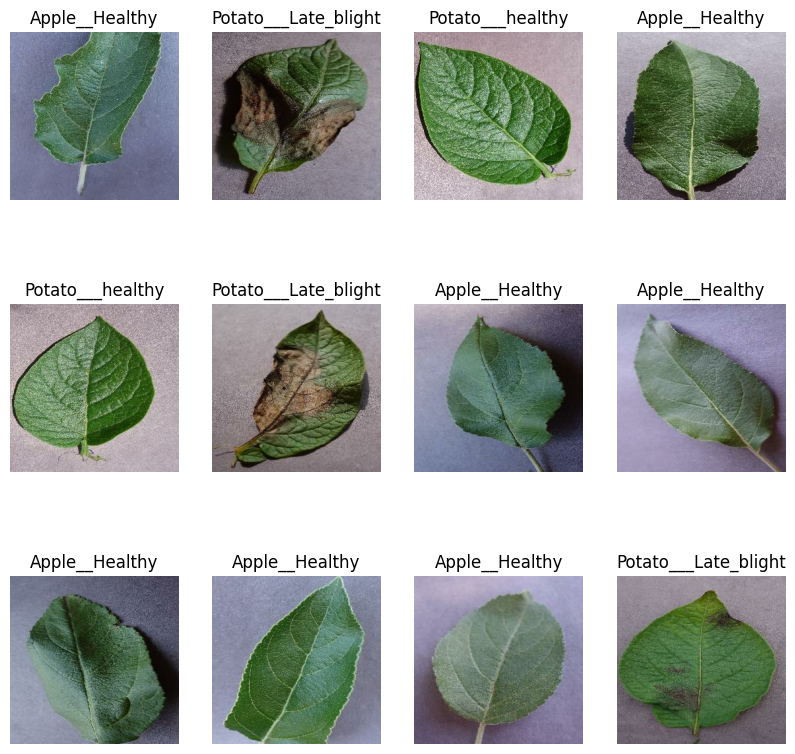

In [9]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [25]:
# 80% => Training
# 20% => 10% validation, 10% testing

In [10]:
train_size = 0.8
len(dataset) * train_size

111.2

In [11]:
train_ds = dataset.take(54) #raa[:54]
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

85

In [14]:
val_size = 0.1
len(dataset) * val_size

13.9

In [15]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [16]:
test_ds = test_ds.skip(6)
len(test_ds)

79

In [17]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
        ds_size = len(ds)

        if shuffle:
            ds = ds.shuffle(shuffle_size, seed=12)
    
        train_size = int(train_split * ds_size)
        val_size = int(val_split * ds_size)

        train_ds = ds.take(train_size)
        val_ds = ds.skip(train_size).take(val_size)
        test_ds = ds.skip(train_size).skip(val_size)
    
        return train_ds, val_ds, test_ds

In [18]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [19]:
len(train_ds)

111

In [20]:
len(val_ds)

13

In [21]:
len(test_ds)

15

In [22]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [23]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [24]:
# Data Augmentation -> If image is flip/rotate
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizonatal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [ ]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load DenseNet121 with pretrained ImageNet weights
base_model = DenseNet121(
    weights="imagenet",
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

# Freeze base model layers
base_model.trainable = False

# Custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
output = Dense(len(class_names), activation="softmax")(x)

model = Model(inputs=base_model.input, outputs=output)

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

In [26]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential (Sequential)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [28]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "../Store-Model/vgg16_model_2.keras",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1
)

history = model.fit(
    train_ds,
    epochs=EPOCH,
    validation_data=val_ds,
    callbacks=[early_stop, checkpoint],
    verbose=1
)

Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5733 - loss: 1.2562
Epoch 1: val_accuracy improved from None to 0.89183, saving model to ../Store-Model/vgg16_model_2.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 344s 3s/step - accuracy: 0.7134 - loss: 0.8806 - val_accuracy: 0.8918 - val_loss: 0.4180
Epoch 2/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8376 - loss: 0.4872
Epoch 2: val_accuracy improved from 0.89183 to 0.92548, saving model to ../Store-Model/vgg16_model_2.keras
111/111 ━━━━━━━━━━━━━━━━━━━━ 340s 3s/step - accuracy: 0.8604 - loss: 0.4271 - val_accuracy: 0.9255 - val_loss: 0.2449
Epoch 3/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8905 - loss: 0.3309
Epoch 3: val_accuracy did not improve from 0.92548
111/111 ━━━━━━━━━━━━━━━━━━━━ 341s 3s/step - accuracy: 0.8975 - loss: 0.3187 - val_accuracy: 0.9255 - val_loss: 0.2162
Epoch 4/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9106 - loss: 0.2840
Epoch 4: val_accuracy improved from 0.92548 

In [32]:
scores = model.evaluate(test_ds)

15/15 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.9917 - loss: 0.0324


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt

y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = model.predict(val_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(xticks_rotation=45, cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', 
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Heatmap Confusion Matrix - EfficientNetB0")
plt.show()

In [33]:
scores

[0.03235864266753197, 0.9916666746139526]

In [34]:
history

In [35]:
history.params

{'verbose': 1, 'epochs': 30, 'steps': 111}

In [36]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [37]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

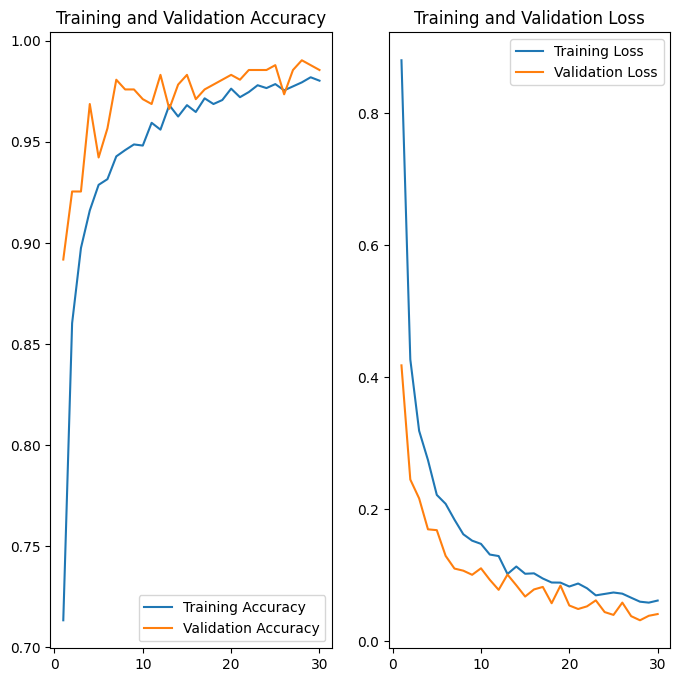

In [38]:
epochs = range(1, len(acc) + 1) 

plt.figure(figsize=(8, 8))

plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

First image to predict


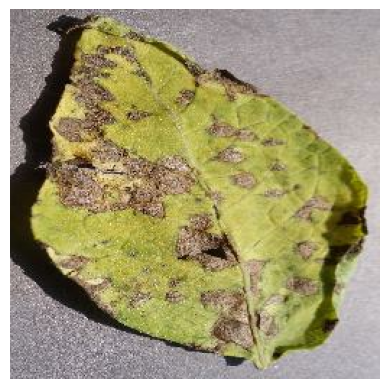

Actual Label :  Potato___Early_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted Label :  Potato___Early_blight


In [39]:
import numpy as np

# Take one batch from the test dataset
for image_batch, label_batch in test_ds.take(1):
    # Get the first image and label in the batch
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = label_batch[0].numpy()

    # Display the image
    print("First image to predict")
    plt.imshow(first_image)
    plt.axis('off')  # hides axis
    plt.show()

    # Print the actual label
    print("Actual Label : ", class_names[first_label])
    
    # Predict the label for the entire batch
    batch_prediction = model.predict(image_batch)
    
    # Get the predicted class of the first image
    predicted_class = np.argmax(batch_prediction[0])
    print("Predicted Label : ", class_names[predicted_class])

In [40]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array, verbose=0)
    
    predicted_index = np.argmax(predictions[0])
    predicted_class = class_names[predicted_index]
    
    confidence = round(100 * np.max(predictions[0]), 2)
    
    return predicted_class, confidence

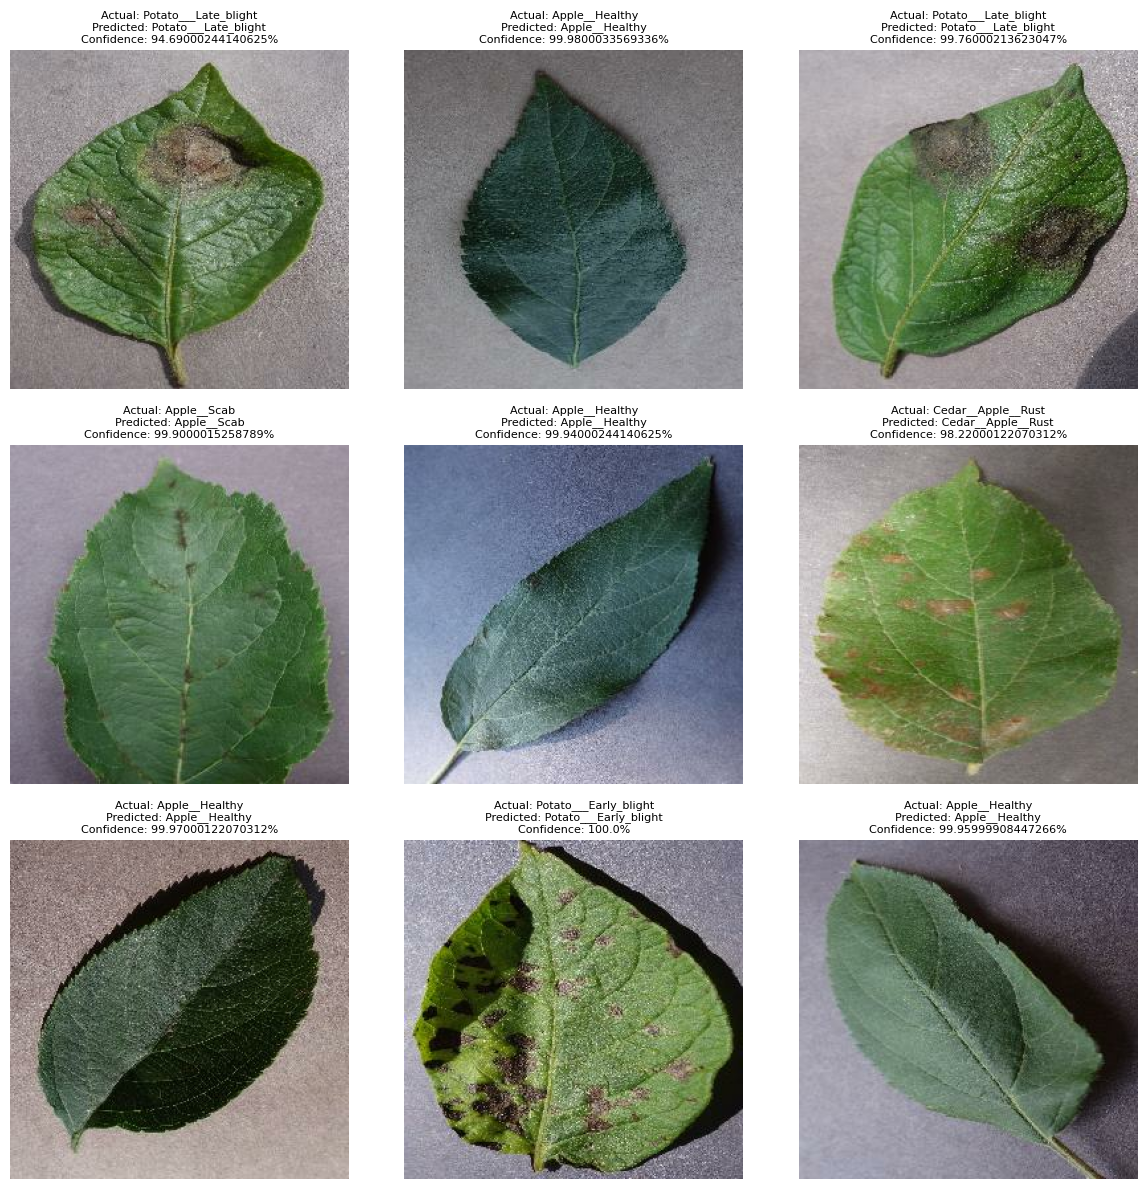

In [41]:
plt.figure(figsize=(12, 12))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))

        predicted_class, confidence = predict(model, images[i])
        actual_class = class_names[labels[i].numpy()]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%", fontsize=8)
        plt.axis("off")
        
plt.tight_layout()
plt.show()

In [ ]:
model.save("../Store-Model/model_densenet121.keras")
print("✅ Model Saved Successfully")